# Classifying Adverse Drug Events (ADEs)

In [8]:
import pandas as pd
from datasets import load_dataset
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from IPython.display import display, HTML

In [2]:
# Load dataset 
dataset = load_dataset("SetFit/ade_corpus_v2_classification")
df = dataset['train'].to_pandas()
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,text,label,label_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related
1,Median patient age was 52 years.,0,Not-Related
2,A whole brain irradiation was performed for 37...,0,Not-Related
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related
4,The fastidious organism grew only on buffered ...,0,Not-Related


### EDA

In [9]:
# Dataset size (observations and features)
n_obs, n_features = df.shape
print(f"Dataset size: {n_obs} observations, {n_features} features")

Dataset size: 17637 observations, 4 features


In [10]:
# Count of adverse drug events (label=1) vs non–adverse events (label=0)
n_ade = (df["label"] == 1).sum()
n_non_ade = (df["label"] == 0).sum()
print(f"Adverse drug events (label=1): {n_ade}")
print(f"Non–adverse events (label=0): {n_non_ade}")

Adverse drug events (label=1): 5145
Non–adverse events (label=0): 12492


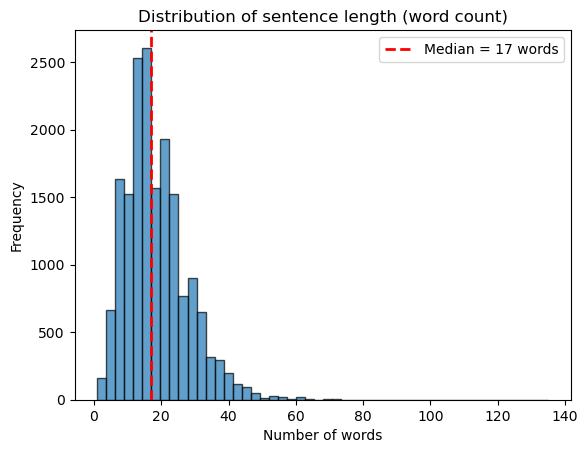

In [11]:
# Histogram of number of words per text, with median
import matplotlib.pyplot as plt

word_counts = df["text"].str.split().str.len()
median_words = word_counts.median()

fig, ax = plt.subplots()
ax.hist(word_counts, bins=50, edgecolor="black", alpha=0.7)
ax.axvline(median_words, color="red", linestyle="--", linewidth=2, label=f"Median = {median_words:.0f} words")
ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of sentence length (word count)")
ax.legend()
plt.show()

### Text Preprocessing

In [3]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaspenney/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucaspenney/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucaspenney/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Uses Penn Treebank POS tags to map parts of speech for better lemmatization with WordNet
def _get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  


def preprocess_text(text):
    """Lowercase, normalize whitespace, tokenize, remove punctuation/digits-only tokens, and lemmatize (POS-aware)."""
    if not isinstance(text, str) or not text.strip():
        return ''
    # Lowercase and normalize whitespace
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove tokens that are only punctuation/digits
    tokens = [t for t in tokens if re.search(r'[a-z]', t)]
    if not tokens:
        return ''

    # POS tag for better lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(token, pos=_get_wordnet_pos(tag))
        for token, tag in pos_tags
    ]
    return ' '.join(lemmatized)


df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,label,label_text,processed_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...
1,Median patient age was 52 years.,0,Not-Related,median patient age be year
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...


### Information Extraction (NER)
- Use the scispaCy BC5CDR model to extract chemicals and diseases from the raw 'text' column
- These chemicals and diseases can be used as extra information for a classification model

In [5]:
# scispaCy BC5CDR model: CHEMICAL (drugs) and DISEASE (conditions/adverse effects)
nlp = spacy.load("en_ner_bc5cdr_md")


def extract_ner_entities(text):
    """Extract drug (chemical) and disease/condition entities from text using scispaCy NER."""
    if not isinstance(text, str) or not text.strip():
        return [], []
    doc = nlp(text)
    drugs = [ent.text for ent in doc.ents if ent.label_ == "CHEMICAL"]
    diseases = [ent.text for ent in doc.ents if ent.label_ == "DISEASE"]
    return drugs, diseases


# Copy df and add NER-derived columns
df_ner = df.copy()
ner_results = df_ner["text"].apply(extract_ner_entities)
df_ner["drug_entities"] = [r[0] for r in ner_results]
df_ner["disease_entities"] = [r[1] for r in ner_results]

df_ner.head()

/opt/anaconda3/envs/DataScience/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


,text,label,label_text,processed_text,drug_entities,disease_entities
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...,[],[]
1,Median patient age was 52 years.,0,Not-Related,median patient age be year,[],[]
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...,"[gefitinib, erlotinib]",[]
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...,[],"[hypocalcemia, hypoparathyroidism, leukemia]"
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...,[charcoal yeast extract],[]


#### NER Validation
- Taking samples of text and visualizing how the scispaCy model is classifying diseases and chemicals

In [ ]:
# Select a few random examples
sample_docs = df_ner[df_ner['drug_entities'].map(len) > 0].sample(5)['text']

for text in sample_docs:
    doc = nlp(text)
    
    # 1. Generate the HTML string with jupyter=False
    html = displacy.render(doc, style="ent", jupyter=False)
    
    # 2. Manually display the HTML using the correct import
    display(HTML(html))
    
    print("---")

---


---


---


---


---
